In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#sns.set()

In [2]:
data = pd.read_csv('../data/creditcard.csv')

In [3]:
data.columns, data.shape

(Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
        'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
        'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
        'Class'],
       dtype='object'), (284807, 31))

In [4]:
data.sample(n=3)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
161487,114230.0,1.970629,-0.222945,-1.602191,0.398875,0.092881,-1.057967,0.366596,-0.249688,0.265101,...,0.034920,0.167301,0.067067,0.053116,0.076266,0.541286,-0.109780,-0.083443,35.95,0
254356,156693.0,1.910231,-0.971814,-1.152019,0.305141,-0.133075,0.776323,-0.654569,0.125540,-0.491098,...,-0.274677,-0.461212,0.055919,-0.415550,-0.072293,-0.670640,0.037861,-0.024572,118.00,0
8882,12169.0,-0.826395,0.958964,1.132115,-1.422683,0.581395,-0.226687,0.567799,-0.078972,1.450484,...,-0.346439,-0.600552,-0.205196,-1.014368,-0.095707,0.769489,0.343610,0.229334,26.00,0


In [5]:
data.Time.min(), data.Time.max()

(0.0, 172792.0)

In [6]:
data.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [7]:
def train_test_split(df):
    df = df.sort_values(by='Time')
    l = int(df.shape[0]*0.8)
    train = df[:l]; test = df[l:]
    y_train = train.Class; y_test = test.Class
    X_train = train.drop(labels=['Class'],axis=1)
    X_test = test.drop(labels=['Class'],axis=1)
    
    return (X_train,y_train,X_test,y_test)

In [8]:
X_train,y_train,X_test,y_test = train_test_split(data)

In [9]:
print ('Percentage of class in train:\n{}'.format(y_train.value_counts()))
print ('\nPercentage of class in test:\n{}'.format(y_test.value_counts()))

Percentage of class in train:
0    227428
1       417
Name: Class, dtype: int64

Percentage of class in test:
0    56887
1       75
Name: Class, dtype: int64


In [10]:
'''# Eliminating Time column in the data

train = train.drop(labels=['Time'],axis=1)
test = test.drop(labels=['Time'],axis=1)'''

"# Eliminating Time column in the data\n\ntrain = train.drop(labels=['Time'],axis=1)\ntest = test.drop(labels=['Time'],axis=1)"

In [11]:
def center_scale(train,test,fet):
    fet_col = train[fet].tolist()
    mu = np.mean(fet_col); sig = np.std(fet_col)
    for i in range(len(fet_col)):
        fet_col[i] = (fet_col[i]-mu)/sig
    train[fet] = fet_col
    fet_col = test[fet].tolist()
    for i in range(len(fet_col)):
        fet_col[i] = (fet_col[i]-mu)/sig
    test[fet] = fet_col
    
    return (train,test)

In [12]:
X_train, X_test = center_scale(X_train,X_test,'Amount')

In [13]:
len(X_train.columns)

30

In [14]:
def univariate_analysis(data,fet,l):
    plt.figure(figsize=(16,l*4))
    print ('Red is FRAUD[Class 1]-----Blue is GENUINE[Class 0]')

    for i,vi in enumerate(data[fet]):
        plt.subplot(l,1,i+1)
        sns.distplot(data[data.Class==0][vi],color='b')
        sns.distplot(data[data.Class==1][vi],color='r')
        plt.xlabel('')
        #plt.ylim(0,max(train_data[train_data.Class==0][vi]*.1))
        plt.title('Dist of feature '+vi)

    plt.savefig('Univariate_analysis_Red_class1_Blue_class0.png')
    plt.show()

Red is FRAUD[Class 1]-----Blue is GENUINE[Class 0]


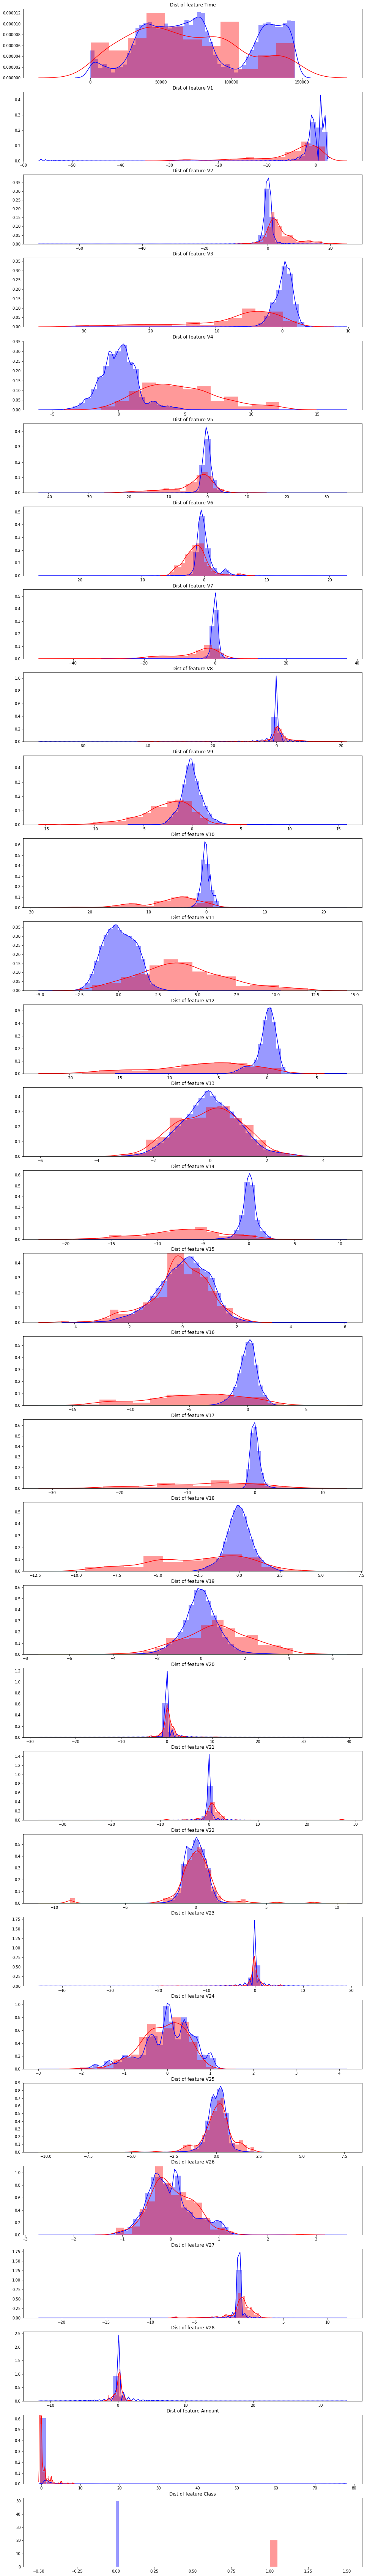

In [15]:
# For feature engineering; Ignore the distribution of class feature
X_train['Class'] = y_train
univariate_analysis(X_train,list(X_train.columns),len(X_train.columns))
X_train = X_train.drop(labels=['Class'],axis=1)

In [20]:
def metric(observed,predicted):
    #y_test = observed; y_pred = predicted
    from sklearn.metrics import precision_recall_fscore_support, roc_auc_score
    pre_rec = precision_recall_fscore_support(observed,predicted)
    roc_auc = roc_auc_score(observed,predicted)
    print ('---Precision:---\n{}\n---Recall:---\n{}\n---AUC:---\n{}'.format(pre_rec[0],pre_rec[1],roc_auc))

In [22]:
def lr_classifier(X_train,X_test,y_train,param):
    from sklearn.linear_model import LogisticRegression
    from sklearn.model_selection import GridSearchCV

    lr = LogisticRegression(class_weight= 'balanced',n_jobs=-1,penalty='l1')
    clf = GridSearchCV(lr,param)
    clf.fit(X_train,y_train)

    lr_parameters = lr.get_params()
    lr_parameters['C'] = clf.best_params_['C']

    lr.set_params(**lr_parameters)
    print ('\n---Parameters for LR---\n{}'.format(lr.get_params))

    lr.fit(X_train,y_train)
    y_pred = lr.predict(X_test)
    
    return (y_pred)

In [19]:
# Implementing a very naive classifier
C = np.arange(1,11,1)
parameter = {'C':list(C)}
y_pred = lr_classifier(X_train,X_test,y_train,parameter)


---Parameters for LR---
<bound method BaseEstimator.get_params of LogisticRegression(C=10, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)>


In [21]:
metric(y_test,y_pred)

---Precision:---
[ 0.99985719  0.07097458]
---Recall:---
[ 0.98458347  0.89333333]
---AUC:---
0.9389584029157219
